In [42]:
# ---- image export setup ----
import sys, subprocess, importlib

def pip_i(spec: str):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])

try:
    import plotly, pkg_resources
    from packaging.version import Version
    if Version(plotly.__version__) < Version("6.1.1"):
        pip_i("plotly>=6.1.1")
except Exception:
    pip_i("plotly>=6.1.1")

# Pin Kaleido to the compatible build
try:
    import kaleido
    from packaging.version import Version
    if Version(kaleido.__version__) != Version("0.2.1"):
        pip_i("kaleido==0.2.1")
except Exception:
    pip_i("kaleido==0.2.1")

import plotly.io as pio

# Only set scope if kaleido is actually loaded
if getattr(pio, "kaleido", None) and getattr(getattr(pio, "kaleido", None), "scope", None):
    pio.kaleido.scope.default_width  = 1600
    pio.kaleido.scope.default_height = 900
else:
    print("Kaleido scope not available yet")

# where to store survey images
from pathlib import Path
SURVEY = (Path().resolve().parent / "figures" / "survey")
SURVEY.mkdir(parents=True, exist_ok=True)
print("Export folder:", SURVEY)


Export folder: /Users/macbookair/Documents/resource_availability_tool/figures/survey


/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_30061/2644509435.py:28: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_width is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_width instead.


/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_30061/2644509435.py:29: DeprecationWarning:


Use of plotly.io.kaleido.scope.default_height is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.default_height instead.




In [43]:
#Setup & paths

from pathlib import Path
import sys, pandas as pd
import plotly.express as px

# src/
SRC = Path().resolve().parent / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from availability import compute_daily_spans, extract_breaks, weekly_availability_matrix
from multitask   import overlap_summary  # robust KPI
from metrics     import regularity_index

DERIV = (Path().resolve().parent / "data" / "derived").resolve()
DERIV


PosixPath('/Users/macbookair/Documents/resource_availability_tool/data/derived')

In [44]:
# Dataset registry & loader helpers

DATASETS = {
    "bpi2017":  {"stem": "bpi2017__tol_5min"},
    "sepsis":   {"stem": "sepsis__tol_5min"},
    "bpi2019":  {"stem": "bpi2019__tol_5min"},
}

def read_frames(stem: str) -> dict:
    """Load all derived frames"""
    def p(name): return (DERIV / f"{stem}_{name}.parquet")
    out = {}
    for key in ["periods","daily_spans","breaks","weekly_availability","task_periods","overlap_kpi"]:
        fp = p(key)
        if fp.exists():
            out[key] = pd.read_parquet(fp)
        else:
            out[key] = pd.DataFrame()
    return out

DS = "sepsis"     # ← switch here: bpi2017 | sepsis | bpi2019
STEM = DATASETS[DS]["stem"]

frames = read_frames(STEM)
periods = frames["periods"].copy()
daily   = frames["daily_spans"].copy()
breaks  = frames["breaks"].copy()
weekly  = frames["weekly_availability"].copy()
tasks   = frames["task_periods"].copy()
olap    = frames["overlap_kpi"].copy()

print(DS, "|",
      "periods:", periods.shape, "|",
      "daily:", daily.shape, "|",
      "breaks:", breaks.shape, "|",
      "weekly:", weekly.shape, "|",
      "tasks:", tasks.shape, "|",
      "overlap_kpi:", olap.shape)
display(periods.head(3))


sepsis | periods: (8494, 6) | daily: (3118, 7) | breaks: (5376, 6) | weekly: (478, 3) | tasks: (0, 0) | overlap_kpi: (0, 0)


,resource,start,end,duration_min,is_overlap,overlap_minutes
0,?,2013-11-22 14:25:53,2013-11-22 14:30:53,5.0,False,0.0
1,?,2013-12-11 11:02:20,2013-12-11 11:07:20,5.0,False,0.0
2,?,2013-12-11 15:35:26,2013-12-11 15:40:26,5.0,False,0.0


In [45]:
# Sanity summary

def _summary(periods, daily, tasks):
    s = {}
    if not periods.empty:
        p = periods.copy()
        p["start"] = pd.to_datetime(p["start"]); p["end"] = pd.to_datetime(p["end"])
        s["n_periods"] = len(p)
        s["periods_range"] = f"[{p['start'].min()} .. {p['end'].max()}]"
        s["resources"] = p["resource"].nunique()
    if not daily.empty:
        s["days"] = daily["day"].nunique()
        s["avg_pct_busy"] = round(float(daily["pct_busy"].mean()), 3)
    if not tasks.empty:
        t = tasks.copy()
        t["duration_min"] = (pd.to_datetime(t["end"]) - pd.to_datetime(t["start"])).dt.total_seconds()/60
        s["tasks"] = len(t)
        s["task_avg_min"] = round(float(t["duration_min"].mean()), 2)
    return s

_summary(periods, daily, tasks)


{'n_periods': 8494,
 'periods_range': '[2013-11-07 08:18:29 .. 2015-06-05 12:30:11]',
 'resources': 26,
 'days': 504,
 'avg_pct_busy': 0.524}

In [46]:
# Arrival & departure distributions (for RQ2 work pattern signatures)

if daily.empty:
    print("No daily_spans for this dataset.")
else:
    d = daily.copy()
    d["arr_hour"] = pd.to_datetime(d["first_start"]).dt.hour
    d["dep_hour"] = pd.to_datetime(d["last_end"]).dt.hour

    fig1 = px.histogram(d, x="arr_hour", nbins=24, title="Arrival time distribution (hour)")
    fig2 = px.histogram(d, x="dep_hour", nbins=24, title="Departure time distribution (hour)")
    fig1.show(); fig2.show()

    fig3 = px.violin(
        d.assign(weekday=pd.to_datetime(d["first_start"]).dt.weekday),
        x="weekday", y="arr_hour", box=True, points="all",
        title="Arrival hour by weekday", labels={"weekday":"Weekday"}
    )
    fig3.show()


In [47]:
# --- Intra-day breaks & lunch presence (for Q2) ---

if breaks.empty:
    print("No breaks extracted.")
else:
    b = breaks.copy()

    # (a) Histogram of break lengths
    fig_breaks = px.histogram(
        b, x="gap_min", nbins=40, title="Intra-day breaks (min)"
    )
    fig_breaks.show()
    fig_breaks.write_image(SURVEY / "Q2_breaks_hist.png", scale=2)

    # (b) Break length by start hour
    fig_byhour = px.violin(
        b, x="start_hour", y="gap_min", box=True, points="all",
        title="Break length by start hour"
    )
    fig_byhour.show()
    fig_byhour.write_image(SURVEY / "Q2_break_by_hour.png", scale=2)

    # (c) Top-15 lunch presence bar (11:30–13:30, 30–120 min)
    bb = b.copy()
    bb["start_hour_real"] = (
        pd.to_datetime(bb["gap_start"]).dt.hour
        + pd.to_datetime(bb["gap_start"]).dt.minute/60
    )
    lunch = (bb.query("11.5 <= start_hour_real <= 13.5 and 30 <= gap_min <= 120")
               .groupby("resource")["day"].nunique())
    active_days = b.groupby("resource")["day"].nunique()
    lunch_rate = (lunch / active_days).fillna(0).rename("lunch_rate").reset_index()

    top_lunch = lunch_rate.sort_values("lunch_rate", ascending=False).head(15)
    fig_top15 = px.bar(
        top_lunch, x="resource", y="lunch_rate",
        title="Estimated lunch presence rate (top 15)"
    )
    fig_top15.update_yaxes(tickformat=".0%")
    fig_top15.show()
    fig_top15.write_image(SURVEY / "Q2_lunch_rate_top15.png", scale=2)


/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_30061/4245605332.py:13: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_30061/4245605332.py:21: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




/var/folders/7j/l7x_10w97357mn1mpd0yhlqc0000gn/T/ipykernel_30061/4245605332.py:41: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [48]:
#Weekly availability (org-wide + top resources) (for RQ2 coverage windows)

if weekly.empty:
    print("No weekly_availability matrix.")
else:
    # org-wide mean
    wavg = weekly.groupby("hour", as_index=False)["availability_share"].mean()
    fig = px.line(wavg, x="hour", y="availability_share",
                  title="Average availability by hour (org-wide)")
    fig.update_yaxes(tickformat=".0%"); fig.show()
    
    low_hours = wavg[wavg["availability_share"] < 0.25]
    print("Low-coverage hours (<25% active):")
    display(low_hours)

    # heatmap for top 10 by days_active
    if not daily.empty:
        top10 = (daily.groupby("resource")["day"].nunique()
                      .sort_values(ascending=False).head(10).index.tolist())
        heat = (weekly[weekly["resource"].isin(top10)]
                .pivot(index="resource", columns="hour", values="availability_share")
                .loc[top10].fillna(0))
        fig = px.imshow(heat, aspect="auto",
                        labels=dict(x="Hour", y="Resource", color="Availability"),
                        title="Hourly availability share — Top 10 resources")
        fig.update_coloraxes(colorbar_tickformat=".0%")
        fig.show()



Low-coverage hours (<25% active):


,hour,availability_share
0,0,0.056362
1,1,0.050672
2,2,0.037211
3,3,0.037125
4,4,0.028432
5,5,0.031059
6,6,0.033987
7,7,0.086618
8,8,0.091238
9,9,0.076691


In [49]:
# Workload timeline of busiest resource

if not periods.empty:
    p = periods.copy()
    p["start"] = pd.to_datetime(p["start"]); p["end"] = pd.to_datetime(p["end"])
    top_res = p["resource"].value_counts().idxmax()
    sub = p[p["resource"] == top_res].copy()
    fig = px.timeline(sub, x_start="start", x_end="end", y="resource",
                      title=f"Task timeline for busiest resource: {top_res}",
                      color_discrete_sequence=["#5B8FF9"])
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.show()


In [50]:
# Overlap pressure (for RQ2 multitasking)

if not olap.empty:
    overlap_kpi = olap.copy()
else:
    if tasks.empty:
        overlap_kpi = pd.DataFrame(columns=["resource","n_periods","busy_min","overlap_min","overlap_share"])
    else:
        overlap_kpi = overlap_summary(tasks)

if overlap_kpi.empty:
    print("No overlap KPI available.")
else:
    px.histogram(overlap_kpi, x="overlap_share", nbins=30,
                 title="Overlap share distribution (overlap minutes / busy minutes)").show()
    px.bar(overlap_kpi.head(10), x="resource", y="overlap_share",
           title="Top 10 resources by overlap share").show()
    display(overlap_kpi.head(10))


No overlap KPI available.


In [51]:
# Day-level anomalies (early/late starts, abnormal span)

if not daily.empty:
    d2 = daily.assign(arr_h=pd.to_datetime(daily["first_start"]).dt.hour)
    med = d2.groupby("resource").agg(med_arr=("arr_h","median"),
                                     med_span=("span_min","median")).reset_index()
    flags = (d2.merge(med, on="resource")
               .query("abs(arr_h - med_arr) > 2 or span_min < 120 or span_min > 720")
               .sort_values(["resource","day"]))
    print(f"Flagged days: {len(flags)}")
    display(flags[["resource","day","arr_h","span_min"]].head(10))


Flagged days: 2593


,resource,day,arr_h,span_min
0,?,2013-11-22,14,5.000000
2,?,2013-12-19,21,5.000000
4,?,2014-01-11,12,5.000000
5,?,2014-01-12,2,910.916667
7,?,2014-01-18,10,5.000000
8,?,2014-01-21,21,5.000000
9,?,2014-01-22,20,5.000000
10,?,2014-01-24,0,969.100000
11,?,2014-01-26,1,5.000000
12,?,2014-01-27,13,5.000000


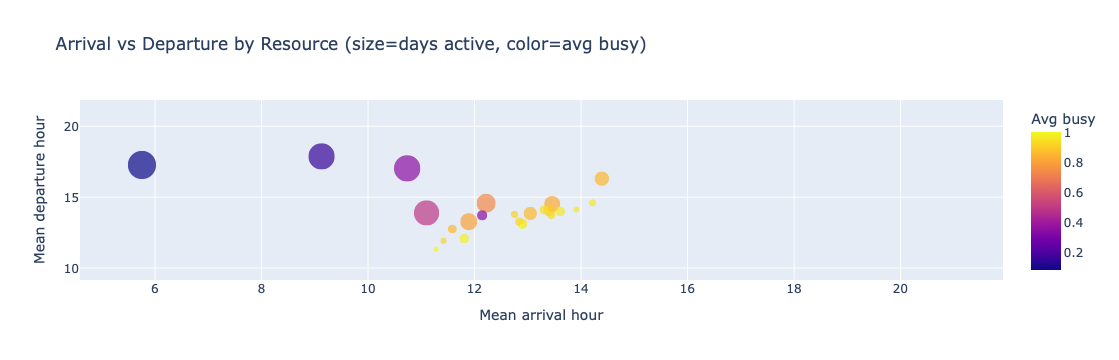

In [52]:
# Resource summary(arrival vs departure, stability & regularity)

if not daily.empty:
    def _res_summary(resource_id: str) -> dict:
        d = daily[daily["resource"] == resource_id]
        reg = regularity_index(daily, resource_id)
        return {
            "resource": resource_id,
            "days_active": d["day"].nunique(),
            "avg_pct_busy": float(d["pct_busy"].mean()),
            "med_pct_busy": float(d["pct_busy"].median()),
            "mean_arr_hour": pd.to_datetime(d["first_start"]).dt.hour.mean(),
            "mean_dep_hour": pd.to_datetime(d["last_end"]).dt.hour.mean(),
            "cv_start": reg["cv_start"],
            "cv_end": reg["cv_end"],
        }

    resources = daily["resource"].unique().tolist()
    summary = pd.DataFrame([_res_summary(r) for r in resources]).sort_values(
        ["days_active","avg_pct_busy"], ascending=[False, False]
    ).reset_index(drop=True)

    fig = px.scatter(
        summary.round(3),
        x="mean_arr_hour", y="mean_dep_hour",
        size="days_active", color="avg_pct_busy",
        hover_data=["resource","med_pct_busy","cv_start","cv_end"],
        labels={"mean_arr_hour":"Mean arrival hour", "mean_dep_hour":"Mean departure hour",
                "avg_pct_busy":"Avg busy"},
        title="Arrival vs Departure by Resource (size=days active, color=avg busy)"
    )
    fig.update_traces(marker=dict(line=dict(width=0)))
    fig.show()


In [53]:
# Task durations 

if tasks.empty:
    print("No task_periods saved in preprocess; skipping duration plots.")
else:
    t = tasks.copy()
    t["start"] = pd.to_datetime(t["start"]); t["end"] = pd.to_datetime(t["end"])
    t["duration_min"] = (t["end"] - t["start"]).dt.total_seconds()/60

    fig1 = px.histogram(t, x="duration_min", nbins=50,
                        title="Task Duration Distribution (minutes)",
                        labels={"duration_min":"Duration (min)"})
    fig1.show()

    # Activity-level durations if activity is present
    if "activity" in t.columns:
        fig2 = px.box(t, x="activity", y="duration_min", points="all",
                      title="Activity Duration Distribution (min)",
                      labels={"duration_min":"Duration (min)"})
        fig2.update_layout(xaxis_title="Activity", yaxis_title="Duration (min)")
        fig2.show()


No task_periods saved in preprocess; skipping duration plots.
